In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyval2d

from sklearn.datasets import make_circles, make_moons, make_blobs 
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from tensorflow.keras.losses import mse, binary_crossentropy


import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras import Model
from keras import backend as K
from keras import objectives



# Sheet 8
### Sheet 7: Regular AutoEncoder 
- compare with VAE fom Sheet 8 

### Questions

- 1-channel what meant by that?
- Why was hidden_size = 2 chosen?
- Any interpretation of the two different latent spaces achieved eith the deeper and 1 layer regular autoencoder? I don't really know how to interpret this

In [5]:
tf.__version__

'2.1.0'

### Images

In [6]:
# # create imagesdef my_polys(degree):
#     coeff = np.random.uniform(0,1,(degree+1,degree+1))
#     # p = polyval2d(x, y, coef) # returns one value
#     p = [[sum([coeff[i,j]*((x/size)**i)*((y/size)**j)
#             for i in range(degree+1) for j in range(degree+1) if (i+j)<=degree]) 
#             for x in range(size)] for y in range(size)]
#     return p

# # one image
# # x = np.linspace(0,1,40)
# # y = np.linspace(0,1,40)
# # x,y = np.meshgrid(x,y)
# # image = my_polys(x,y,5)

# maxdegree = 5
# size = 40
# num_polys = 1000 # number of 
# dataset = np.array([my_polys(np.random.randint(0,maxdegree)) for i in range(num_polys)])
# dataset = tf.keras.utils.normalize(dataset)

# numpy.polynomial.polynomial.polyval2d does what was written in forum on how to create images
# Row numbers in V correspond to powers of x, while column numbers in V correspond to powers of y



(1000, 40, 40)


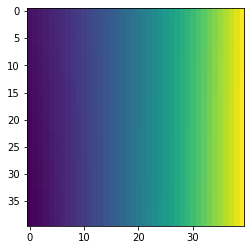

In [7]:
print(np.shape(dataset))

plt.imshow(dataset[50])

Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.

In [ ]:
size = 40

# Evaluate polynomial over grid of size 40x40

def polynomial(degree):
    coeff = np.random.normal(0,1,(degree+1, degree+1))
    #coeff = np.random.uniform(-1,1,(degree+1, degree+1))
    return [[sum([coeff[i,j]*((x/size)**i)*((y/size)**j)
            for i in range(degree+1) for j in range(degree+1) if (i+j)<=degree]) 
            for x in range(size)] for y in range(size)]

# Degree two polynomials

Npoly = 3000
deg2polydata = np.array([polynomial(2) for i in range(Npoly)])
deg2polydata = deg2polydata.reshape(Npoly, size*size)
deg2mean = np.mean(deg2polydata)
deg2sdev = np.std(deg2polydata)
deg2polydata = tf.keras.utils.normalize(deg2polydata)
np.save('deg2polydata.npy', deg2polydata)

### Autoencoder
- Build two autoencoder architectures (e.g. similar to the ones presented in the lecture)
- a single hidden dense layer and several hidden dense layers.

In [8]:
# single hidden layer

input_size = size**2
hidden_size = 2 # latent dim 
output_size = size**2
batch_size=100

polydata = dataset.reshape(num_polys, size**2)

inputs = Input(shape=(input_size,))

# hidden layer
AE1encoded = Dense(2, activation='linear')(inputs) # encoded

AE1decoded = Dense(size**2, activation='linear')(AE1encoded) # decoded, lossy reconstruction of the input

# this model maps an input to its reconstruction
AE1 = Model(inputs, AE1decoded)

# Now let's train our autoencoder
AE1.compile(optimizer='adam', loss='mse')
AE1_initial_weights = AE1.get_weights()

# train one layer encoder
hist = AE1.fit(polydata, polydata, epochs=10, batch_size=100)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 454us/sample - loss: 0.0228
Epoch 2/10
1000/1000 [==============================] - 0s 108us/sample - loss: 0.0161
Epoch 3/10
1000/1000 [==============================] - 0s 68us/sample - loss: 0.0095
Epoch 4/10
1000/1000 [==============================] - 0s 88us/sample - loss: 0.0050
Epoch 5/10
1000/1000 [==============================] - 0s 77us/sample - loss: 0.0026
Epoch 6/10
1000/1000 [==============================] - 0s 63us/sample - loss: 0.0014
Epoch 7/10
1000/1000 [==============================] - 0s 113us/sample - loss: 9.7769e-04
Epoch 8/10
1000/1000 [==============================] - 0s 63us/sample - loss: 7.9666e-04
Epoch 9/10
1000/1000 [==============================] - 0s 94us/sample - loss: 7.2778e-04
Epoch 10/10
1000/1000 [==============================] - 0s 72us/sample - loss: 7.0280e-04


(1000,)


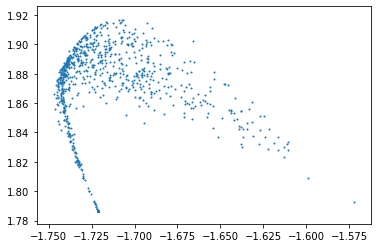

In [9]:
# this model maps an input to its encoded representation
# model which computes the output of the hidden layer
AE1_latent = Model(inputs, AE1encoded)

# encode and decode some images
AE1_encoded = AE1_latent.predict(polydata)

# plot the latent dims
# print(np.shape(AE1_encoded))
print(AE1_encoded[:,0].shape)
_ = plt.scatter(AE1_encoded[:,0], AE1_encoded[:,1],s=1)

In [10]:
# several hidden dense layers

intermediate_dim1 = 512
intermedite_dim2 = 64
latent_dim = 2

AE2compress1 = Dense(512, activation='relu')(inputs)
AE2compress2 = Dense(64, activation='relu')(AE2compress1)

AE2encoded = Dense(2, activation='linear')(AE2compress2)


AE2decompress1 = Dense(64, activation='relu')(AE2encoded)
AE2decompress2 = Dense(512, activation='relu')(AE2decompress1)
AE2decoded = Dense(size**2, activation='linear')(AE2decompress2)

AE2 = Model(inputs, AE2decoded)
AE2.compile(optimizer='adam', loss='mse')
AE2_initial_weights = AE2.get_weights()

print(np.shape(polydata))

# compile and train the larger autoencoder
hist_large = AE2.fit(polydata, polydata, epochs=200, batch_size=100)

(1000, 1600)
Train on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 1s 799us/sample - loss: 0.0128
Epoch 2/200
1000/1000 [==============================] - 0s 333us/sample - loss: 0.0016
Epoch 3/200
1000/1000 [==============================] - 0s 317us/sample - loss: 9.2553e-04
Epoch 4/200
1000/1000 [==============================] - 0s 322us/sample - loss: 7.6822e-04
Epoch 5/200
1000/1000 [==============================] - 0s 344us/sample - loss: 6.9810e-04
Epoch 6/200
1000/1000 [==============================] - 0s 316us/sample - loss: 6.3333e-04
Epoch 7/200
1000/1000 [==============================] - 0s 339us/sample - loss: 4.8754e-04
Epoch 8/200
1000/1000 [==============================] - 0s 342us/sample - loss: 2.3173e-04s - loss: 3.0419e
Epoch 9/200
1000/1000 [==============================] - 0s 344us/sample - loss: 7.9652e-05
Epoch 10/200
1000/1000 [==============================] - 0s 333us/sample - loss: 4.1154e-05
Epoch 11/200
1000/1000 [===========

1000/1000 [==============================] - 0s 358us/sample - loss: 2.4363e-05
Epoch 176/200
1000/1000 [==============================] - 0s 333us/sample - loss: 2.4261e-05
Epoch 177/200
1000/1000 [==============================] - 0s 331us/sample - loss: 2.3921e-05
Epoch 178/200
1000/1000 [==============================] - 0s 330us/sample - loss: 2.3942e-05
Epoch 179/200
1000/1000 [==============================] - 0s 343us/sample - loss: 2.4373e-05
Epoch 180/200
1000/1000 [==============================] - 0s 352us/sample - loss: 2.4448e-05
Epoch 181/200
1000/1000 [==============================] - 0s 322us/sample - loss: 2.4015e-05
Epoch 182/200
1000/1000 [==============================] - 0s 320us/sample - loss: 2.4480e-05
Epoch 183/200
1000/1000 [==============================] - 0s 376us/sample - loss: 2.4069e-05
Epoch 184/200
1000/1000 [==============================] - 0s 354us/sample - loss: 2.3836e-05
Epoch 185/200
1000/1000 [==============================] - 0s 412us/sample

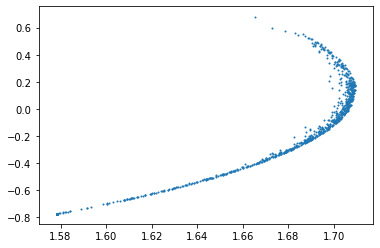

In [11]:
# more complex autoencoder

# model which computes the output of the hidden layer
AE2_latent = Model(inputs, AE2encoded)

# plot latent dimensions
AE2_encoded = AE2_latent.predict(polydata)
AE2_encoded[:,0].shape
plt.scatter(AE2_encoded[:,0], AE2_encoded[:,1],s=1)

# Sheet 8 
I am just copy pasting some info which I found helpful, so I can access it later. I left it in here because I thought I could be interesting. 
### VAE
- VAE is an autoencoder whose encodings distribution is regularised during the training in order to ensure that its latent space has good properties allowing us to generate some new data

### PCA
- idea of PCA is to build n_e new independent features that are linear combinations of the n_d old features
- best linear subspace of the initial space

### Regular autoencoder 
- difference to PCA: Moreover, for linear autoencoders and contrarily to PCA, the new features we end up do not have to be independent (no orthogonality constraints in the neural networks). PCA uses linear transformation whereas autoencoders use non-linear transformations.
- once the autoencoder has been trained, we have both an encoder and a decoder but still no real way to produce any new content.
- we could take a point randomly from that latent space and decode it to get a new content. regularity of the latent space for autoencoders is a difficult point that depends on the distribution of the data in the initial space, the dimension of the latent space and the architecture of the encoder. So, it is pretty difficult (if not impossible) to ensure, a priori, that the encoder will organize the latent space in a smart way compatible with the generative process we just described.
- Possible issue: severe overfitting implying that some points of the latent space will give meaningless content once decoded.
- ndeed, nothing in the task the autoencoder is trained for enforce to get such organisation: the autoencoder is solely trained to encode and decode with as few loss as possible, no matter how the latent space is organised.
- unless we explicitly regularise it, natural that, during the training, the network takes advantage of any overfitting possibilities to achieve its task as well as it can

### VAE
- to be able to use the decoder of our autoencoder for generative purpose, we have to be sure that the latent space is regular enough. 
- training is regularised to avoid overfitting
- instead of encoding an input as a single point, we encode it as a distribution over the latent space
- The model is then trained as follows:
    - first, the input is encoded as distribution over the latent space
    - second, a point from the latent space is sampled from that distribution
    - third, the sampled point is decoded and the reconstruction error can be computed
    - finally, the reconstruction error is backpropagated through the network
    
- tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution.
- regularisation term is expressed as the Kulback-Leibler divergence between the returned distribution and a standard Gaussian 

- we have to regularise both the covariance matrix and the mean of the distributions returned by the encoder -> No "points", very tight gaussians; --> no spaced out means
-  this regularisation is done by enforcing distributions to be close to a standard normal distribution (centred and reduced);  mean to be close to 0

- The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution


In [12]:
# tf.executing_eagerly()

# inputs = Input(shape=(input_size,))
# hidden_size = 2 # latent dim 
# batch_size=100

intermediate_dim = 512
latent_dim = 2
input_size = size**2
original_dim = size**2

AE2compress1_vae = Dense(512, activation='relu')(inputs)
AE2encoded_vae = Dense(2, activation='linear')(AE2compress1_vae)
z_mean = AE2encoded_vae
z_log_sigma =  AE2encoded_vae

# sample a point similar to a point in latent space
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

# encoder model
encoder = Model(inputs, [z_mean, z_log_sigma, z])
encoder.summary()

# build decoder model 
latent_inputs = Input(shape=(latent_dim,))
AE2decompress2_vae = Dense(512, activation='relu')(latent_inputs)
AE2decoded_vae = Dense(size**2, activation='linear')(AE2decompress2_vae)
outputs = AE2decoded_vae

# decoder model 
decoder = Model(latent_inputs, outputs) 
decoder.summary()

# we need 3 models: third one is end-to-end autoencoder
outputs = decoder(encoder(inputs)[2]) # what does this do exactly, why necessary
vae = Model(inputs, outputs)

# loss function: the sum of a reconstruction term, and the KL divergence regularization term
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

# reconstruction_loss = binary_crossentropy(inputs,outputs)
# reconstruction_loss *= original_dim
# kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600)]       0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          819712      input_1[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 2)            1026        dense_8[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (100, 2)             0           dense_9[0][0]                    
                                                                 dense_9[0][0]              

In [13]:
# tf.compat.v1.disable_eager_execution()

print(np.shape(polydata))

hist_vae = vae.fit(polydata, polydata, epochs=4, batch_size=100)

(1000, 1600)
Train on 1000 samples
Epoch 1/4
 100/1000 [==>...........................] - ETA: 4s

_SymbolicException: Inputs to eager execution function cannot be Keras symbolic tensors, but found [<tf.Tensor 'dense_9/Identity:0' shape=(None, 2) dtype=float32>]

Since I keep getting an error when fitting vae I can't really compare the performance. 
But in the latent space of the VAE the point should be close together somewhat organised. The further away the points are the less similar the decoded output is. This was not e

In [ ]:
# plot latent dimensions
l = encoder.predict(polydata)
# AE2_encoded_vae[:,0].shape
# plt.scatter(AE2_encoded_vae[:,0], AE2_encoded_vae[:,1],s=1)